In [6]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds, rdMolTransforms, rdDepictor, Draw

import py3Dmol
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
IPythonConsole.ipython_3d = True
IPythonConsole.drawOptions.addAtomIndices = True

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.isomorphism as iso

from pathlib import Path
from copy import deepcopy

In [7]:
def split_xyz_trajectory(trj_path: Path):
    """ Read an XYZ file with multiple molecule entries (may be distinct molecules)
        and return list of XYZ string blocks
    """
    frames = []
    n_atoms = None
    line_count = None
    with trj_path.open("r") as trj:
        for line in map(lambda l: l.rstrip(), trj.readlines()):
            if not n_atoms and line.isdigit():
                n_atoms = int(line)
                frame = [line]
                line_count = 0
                
            elif n_atoms == line_count:
                line_count += 1
                n_atoms = None
                frame.append(line)
                frames.append("\n".join(frame))
                
            else:
                line_count += 1
                frame.append(line)
    return frames


def read_xyz_trajectory(frames):
    """ Convert a list of XYZ strings
        to the list of RDKit molecules.
        Also guess the bonds
    """
    rd_frames = []
    for xyz_block in frames:
        frame = Chem.MolFromXYZBlock(xyz_block)
        rdDetermineBonds.DetermineConnectivity(frame)
        rd_frames.append(frame)
    return rd_frames


def get_molecule_graph(rd_mol):
    molecule_graph = nx.Graph()
    for atom in rd_mol.GetAtoms():
        idx = atom.GetIdx()
        element = atom.GetSymbol()
        label=f"{element.lower()}{idx}"
        molecule_graph.add_node(
            idx,
            element=element,
            label=label,
        )
    for bond in rd_mol.GetBonds():
        molecule_graph.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
        )
    return molecule_graph


def get_bad(molecule_graph):
    """ Find all bonds, angles and dihedrals in RDMol
        and return its atom indexes as correspondigly,
        sets of 2-, 3-, and 4-tuples
    """
    # Query Subgraphs
    angle_subgraph = nx.Graph()
    angle_subgraph.add_edges_from([("a", "b"), ("b", "c")])
    dihedral_subgraph = nx.Graph()
    dihedral_subgraph.add_edges_from([("a", "b"), ("b", "c"), ("c", "d")])

    # Get Bonds
    bonds = set(molecule_graph.edges)

    # Get Angles
    angle_subgraph_match = iso.GraphMatcher(molecule_graph, angle_subgraph)
    angles = set()
    for subgraph in angle_subgraph_match.subgraph_isomorphisms_iter():
        angle = tuple(subgraph.keys())
        if angle[0] < angle[-1]:
            angles.add(angle)
        else:
            angles.add(angle[::-1])

    # Get Dihedrals
    dihedral_subgraph_match = iso.GraphMatcher(molecule_graph, dihedral_subgraph)
    dihedrals = set()
    for subgraph in dihedral_subgraph_match.subgraph_isomorphisms_iter():
        dihedral = tuple(subgraph.keys())
        if dihedral[0] < dihedral[-1]:
            dihedrals.add(dihedral)
        else:
            dihedrals.add(dihedral[::-1])
   
    return bonds, angles, dihedrals


def extract_geometry_params(rd_mol, frame=0):
    molecule_graph = get_molecule_graph(rd_mol)
    bonds, angles, dihedrals = get_bad(molecule_graph)
    parameters = {"frame": frame}
    conformer = rd_mol.GetConformer()
    positions = conformer.GetPositions()

    for s, e in bonds:
        name = (
            f"{molecule_graph.nodes[s]['label']}"
            f"-{molecule_graph.nodes[e]['label']}"
        )
        dist = np.linalg.norm(
            positions[s] - positions[e]
        )
        parameters[name] = dist

    for l, m, r in angles:
        name = (
            f"{molecule_graph.nodes[l]['label']}"
            f"-{molecule_graph.nodes[m]['label']}"
            f"-{molecule_graph.nodes[r]['label']}"
        )
        angle = rdMolTransforms.GetAngleDeg(conformer, l, m, r)
        parameters[name] = angle

    for ll, lm, rm, rr in dihedrals:
        name = (
            f"{molecule_graph.nodes[ll]['label']}"
            f"-{molecule_graph.nodes[lm]['label']}"
            f"-{molecule_graph.nodes[rm]['label']}"
            f"-{molecule_graph.nodes[rr]['label']}"
        )
        dihedral = rdMolTransforms.GetDihedralDeg(conformer, ll, lm, rm, rr)
        parameters[name] = dihedral if dihedral < 170 else dihedral - 360
    
    return parameters


def process_trajectory_params(trajectory):
    entries = [
        extract_geometry_params(rd_mol, frame)
        for frame, rd_mol in enumerate(trajectory)
    ]
    return pd.DataFrame.from_records(entries)

In [8]:
eg_0_traj = read_xyz_trajectory(
    split_xyz_trajectory(
        Path("ethylene_glycol/eg_0_trj.xyz")
    )
)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

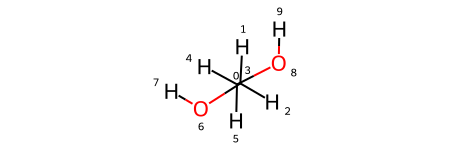

In [9]:
eg_0_traj[-1]

In [10]:
eg_0_2d = deepcopy(eg_0_traj[0])
rdDepictor.Compute2DCoords(eg_0_2d)
d = rdMolDraw2D.MolDraw2DCairo(400, 300)
d.drawOptions().addAtomIndices = True
d.DrawMolecule(eg_0_2d)
d.FinishDrawing()
d.WriteDrawingText("ethylene_glycol/atom_mapping.png")

![](ethylene_glycol/atom_mapping.png)

In [11]:
df = process_trajectory_params(eg_0_traj)

In [12]:
bonds = ['c0-h1', 'c3-o8', 'c3-h4', 'c0-c3', 'c0-o6', 'o6-h7', 'c0-h2', 'o8-h9', 'c3-h5']
angles = ['h4-c3-h5', 'c0-c3-h4', 'c3-c0-o6', 'h2-c0-c3', 'h4-c3-o8', 'c0-o6-h7', 'h5-c3-o8', 'h1-c0-o6', 'h1-c0-c3', 'c3-o8-h9', 'c0-c3-h5', 'h1-c0-h2', 'c0-c3-o8', 'h2-c0-o6']
dihedrals = ['h2-c0-c3-h5', 'h5-c3-o8-h9', 'h1-c0-o6-h7', 'c3-c0-o6-h7', 'c0-c3-o8-h9', 'h2-c0-c3-o8', 'h2-c0-c3-h4', 'h2-c0-o6-h7', 'h4-c3-c0-o6', 'o6-c0-c3-o8', 'h1-c0-c3-h5', 'h1-c0-c3-o8', 'h1-c0-c3-h4', 'h4-c3-o8-h9', 'h5-c3-c0-o6']

In [13]:
ddesc = df[bonds].describe().T
ddesc.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
c0-o6,11.0,1.456241,0.005919,1.440000,1.455839,1.456811,1.459335,1.462135
c3-o8,11.0,1.455877,0.005560,1.440000,1.455798,1.456619,1.458713,1.460403
c0-c3,11.0,1.525494,0.003539,1.520212,1.523558,1.524856,1.528399,1.530493
c0-h2,11.0,1.087650,0.002644,1.086067,1.086365,1.086465,1.087507,1.095068
c3-h5,11.0,1.087162,0.002642,1.086084,1.086175,1.086340,1.086458,1.095068
o8-h9,11.0,0.972789,0.002238,0.966131,0.973441,0.973526,0.973618,0.973708
o6-h7,11.0,0.972084,0.002227,0.966130,0.971647,0.972866,0.973533,0.973694
c3-h4,11.0,1.096757,0.001034,1.095068,1.095965,1.096935,1.097807,1.097920
c0-h1,11.0,1.096982,0.000943,1.095068,1.096366,1.097067,1.097829,1.097947


In [14]:
andesc = df[angles].describe().T
andesc.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
h4-c3-o8,11.0,110.927833,1.268392,107.494034,110.958142,111.055550,111.609919,112.141902
h1-c0-o6,11.0,110.928604,1.266639,107.493983,110.980376,111.056444,111.569534,112.126757
h2-c0-o6,11.0,106.389294,0.820589,105.578586,105.813634,105.853622,107.165734,107.703104
h5-c3-o8,11.0,105.938546,0.685934,105.128201,105.603094,105.825131,105.994381,107.493963
c3-c0-o6,11.0,110.867024,0.648471,109.866237,110.304540,111.190249,111.429080,111.455445
c0-c3-h5,11.0,109.707838,0.647442,109.013819,109.336860,109.591158,109.746979,111.382651
c0-o6-h7,11.0,110.522423,0.596906,108.998684,110.349947,110.460532,110.942329,111.179118
h2-c0-c3,11.0,109.741591,0.596813,109.215026,109.440238,109.644509,109.704949,111.382642
h4-c3-h5,11.0,108.426305,0.505230,107.493991,108.263462,108.422318,108.763551,109.140444
c3-o8-h9,11.0,110.303774,0.497649,108.998630,110.292859,110.380694,110.557908,110.826776


In [15]:
dhdesc = df[dihedrals].describe().T
dhdesc.sort_values("std", ascending=False)

,count,mean,std,min,25%,50%,75%,max
h2-c0-o6-h7,11.0,-159.037194,14.605261,-171.749217,-171.650493,-166.876691,-145.708476,-135.840575
h1-c0-o6-h7,11.0,-41.378402,14.310052,-54.315633,-53.960144,-48.357230,-27.450228,-20.385123
c3-c0-o6-h7,11.0,81.683475,13.876966,69.067258,69.399751,75.093098,95.251468,101.887133
h5-c3-o8-h9,11.0,-168.659726,4.873034,-173.123108,-172.258634,-172.018900,-165.004087,-159.614893
h4-c3-o8-h9,11.0,-51.200398,4.302462,-55.083882,-54.715524,-53.871535,-47.385804,-44.159460
c0-c3-o8-h9,11.0,72.119019,4.058710,68.409427,68.656018,69.838621,76.055126,78.112842
o6-c0-c3-o8,11.0,-185.540986,2.316000,-188.261064,-186.873616,-185.599247,-185.391180,-180.000000
h2-c0-c3-o8,11.0,57.211307,1.200108,55.730120,56.412743,57.314645,57.763784,59.999950
h1-c0-c3-o8,11.0,-62.186415,1.188091,-63.887383,-63.010193,-62.145870,-61.577863,-60.000034
h5-c3-c0-o6,11.0,57.509952,1.069451,56.166631,56.844201,57.516285,57.771981,60.000034


In [16]:
angles_sel = ["h4-c3-o8", "h1-c0-o6", "c3-c0-o6", "c0-o6-h7"]
dihedrals_sel = ["c3-c0-o6-h7", "c0-c3-o8-h9", "o6-c0-c3-o8"]

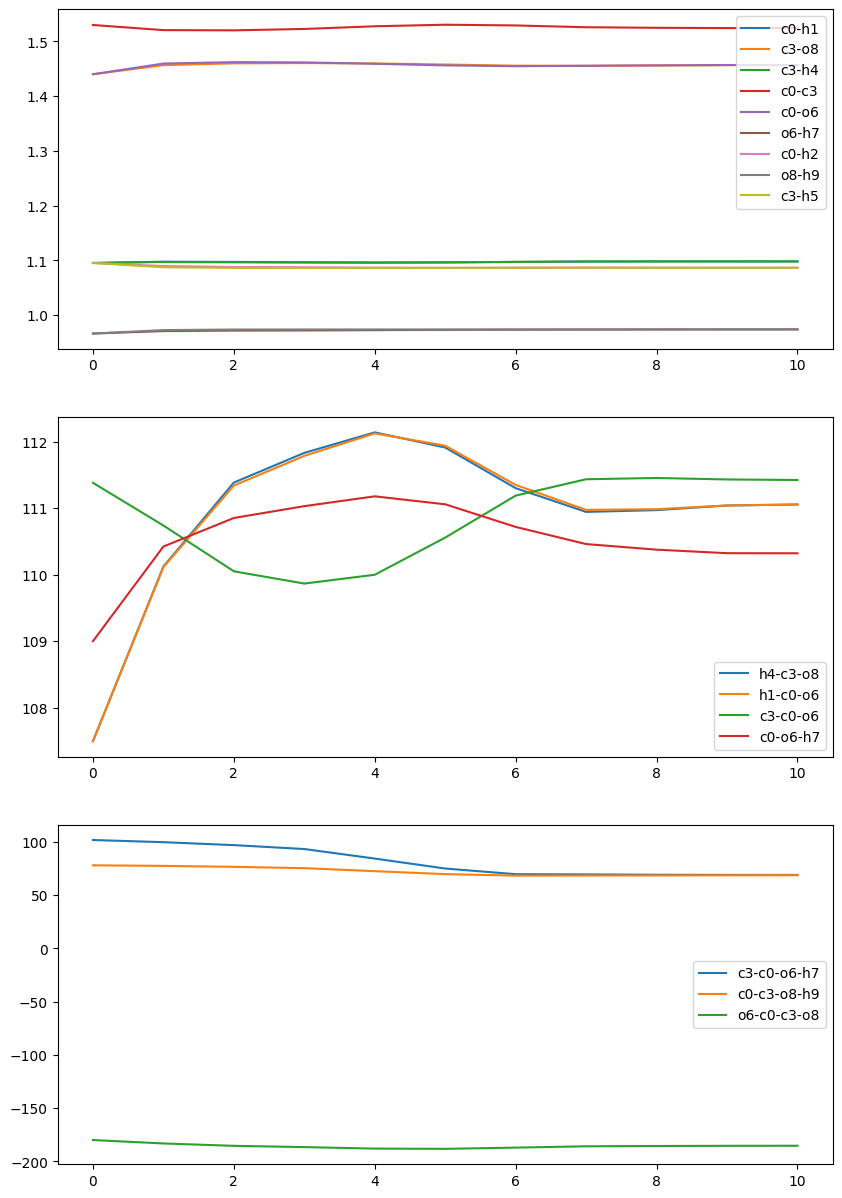

In [17]:
fig, axes = plt.subplots(figsize=(10,15), nrows=3)
for ax, param_set in zip(axes, [bonds, angles_sel, dihedrals_sel]):
    for param in param_set:
        ax.plot(
            df["frame"],
            df[param],
            label=param
        )
        ax.legend()

In [21]:
print(df[bonds+angles_sel+dihedrals_sel].T[[0, 10]].to_markdown())

|             |           0 |          10 |
|:------------|------------:|------------:|
| c0-h1       |    1.09507  |    1.0979   |
| c3-o8       |    1.44     |    1.45673  |
| c3-h4       |    1.09507  |    1.09788  |
| c0-c3       |    1.52999  |    1.52444  |
| c0-o6       |    1.44     |    1.45684  |
| o6-h7       |    0.96613  |    0.973694 |
| c0-h2       |    1.09507  |    1.08636  |
| o8-h9       |    0.966131 |    0.973704 |
| c3-h5       |    1.09507  |    1.08635  |
| h4-c3-o8    |  107.494    |  111.056    |
| h1-c0-o6    |  107.494    |  111.056    |
| c3-c0-o6    |  111.383    |  111.425    |
| c0-o6-h7    |  108.999    |  110.322    |
| c3-c0-o6-h7 |  101.887    |   69.0673   |
| c0-c3-o8-h9 |   78.1128   |   68.8024   |
| o6-c0-c3-o8 | -180        | -185.368    |


In [19]:
!pip install tabulate


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
